### Bibliotecas

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import random

#bibliotecas para geração de gráficos
from matplotlib import pyplot as plot
import statsmodels.formula.api as smf
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

#fazer a decomposição da série temporal
from statsmodels.tsa.seasonal import seasonal_decompose

#Biblioteca do XGBoost
from xgboost import XGBRegressor

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.tree import DecisionTreeRegressor # for building the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

### Base de dados

In [2]:
#Importando base - Windows
df = pd.read_excel(r'D:/Google Drive/PC - Casa/MBA - USP ESALQ/Data Science/00. TCC/01. Base de Dados/2024_09_30 - Base.xlsx')

df = df.drop(0)
df.reset_index(inplace=True)
df = df.drop(columns=['index'])

### Análise

#### Criando 2 bases para teste dos modelos
##### * Base 1: Usando os valores dos indicadores em base 100
##### * Base 2: Usando os valores absolutos dos indicadores

In [3]:
# Selecionando a coluna 'CUB - R1-B', ano mes e as colunas que começam com 'base_100'
colunas_selecionadas = ['ano_mes', 'cub'] + [col for col in df.columns if col.startswith('base100_')]

# Filtrando o DataFrame para incluir apenas as colunas selecionadas
df_tratado = df[colunas_selecionadas]

In [4]:
# Substituindo os valores nulos pela mediana
## Obs: Justificar no texto do TCC o por que ficou ruim pela média.

median_values = df_tratado.median() #Ficou ruim pela média
df_tratado_1 = df_tratado.fillna(median_values)

C:\Users\rique\AppData\Local\Temp\ipykernel_1124\785062747.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tratado_1 = df_tratado.fillna(median_values)


In [5]:
#Selecionando as colunas apenas com valores absolutos dos indicadores
df_tratado_2 = df.drop(columns=colunas_selecionadas)

#Substituindo nulos pelos valores médios
median_values = df_tratado_2.median() #Ficou ruim pela média
df_tratado_2 = df_tratado_2.fillna(median_values)
df_tratado_2.fillna(median_values, inplace=True)

C:\Users\rique\AppData\Local\Temp\ipykernel_1124\3189122234.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tratado_2 = df_tratado_2.fillna(median_values)


#### Separando os valores dependentes e independentes das duas bases

In [6]:
#Listando os nomes das colunas do dataset 1
df_tratado_1.columns

Index(['ano_mes', 'cub', 'base100_pim', 'base100_iabr', 'base100_ipca',
       'base100_snic', 'base100_PIB-Brasil', 'base100_PIB-CC', 'base100_IGMR',
       'base100_lancadas_ABRAINC', 'base100_vendidas_ABRAINC',
       'base100_distratadas_ABRAINC', 'base100_incc_di'],
      dtype='object')

In [7]:
#Listando os nomes das colunas do dataset 2
df_tratado_2.columns

Index(['anomes', 'CUB - R1-B', 'PIM-PF', 'IABR', 'IPCA', 'SNIC', 'PIB-Brasil',
       'PIB-CC', 'IGMR', 'Unidades lançadas (ABRAINC)',
       'Unidades vendidas (ABRAINC)', 'Unidades distratadas (ABRAINC)',
       'incc_di'],
      dtype='object')

In [8]:
#Listando as colunas dependentes da base 1
cols_independentes_1 = ['base100_pim', 'base100_iabr', 'base100_ipca', 'base100_snic',
       'base100_PIB-Brasil', 'base100_PIB-CC', 'base100_IGMR',
       'base100_lancadas_ABRAINC', 'base100_vendidas_ABRAINC',
       'base100_distratadas_ABRAINC', 'base100_incc_di']


#Separando em dependentes (X_1) e independentes (Y_1)

#Dependentes
X_1 = df_tratado_1[cols_independentes_1]
#Independente
Y_1 = df_tratado_1[['cub']]

In [9]:
#Listando as colunas dependentes da base 2
cols_independentes_2 = ['PIM-PF', 'IABR', 'IPCA', 'SNIC', 'PIB-Brasil',
       'PIB-CC', 'IGMR', 'Unidades lançadas (ABRAINC)',
       'Unidades vendidas (ABRAINC)', 'Unidades distratadas (ABRAINC)',
       'incc_di']


#Separando em dependentes (X_2) e independentes (Y_2)

#Dependentes
X_2 = df_tratado_2[cols_independentes_2]
#Independente
Y_2 = df_tratado_2[['CUB - R1-B']]

#### Adicionando as duas colunas [ano e mês] nas duas bases

In [10]:
#Separando as colunas ano_mes para cada base

#base 1
df_tratado_1['ano'] = df_tratado_1['ano_mes'].apply(lambda x: int(x.split('_')[0]))
df_tratado_1['mes'] = df_tratado_1['ano_mes'].apply(lambda x: int(x.split('_')[1]))

#base 2
df_tratado_2['ano'] = df_tratado_2['anomes'].apply(lambda x: int(x.split('_')[0]))
df_tratado_2['mes'] = df_tratado_2['anomes'].apply(lambda x: int(x.split('_')[1]))

In [11]:
#Adicionando as colunas ano e mes nos datasets de variaveis dependentes
X_1 = X_1.join(df_tratado_1[['ano', 'mes']])
X_2 = X_2.join(df_tratado_2[['ano', 'mes']])

In [12]:
#Criando os datasets de treino 1 & 2
##Base 1: Usando os valores dos indicadores em base 100
##Base 2: Usando os valores absolutos dos indicadores
X_train_1 = X_1[X_1['ano'] < 2024]
y_train_1 = Y_1.loc[X_train_1.index]

X_train_2 = X_2[X_2['ano'] < 2024]
y_train_2 = Y_2.loc[X_train_2.index]

### Parametrização dos modelos

In [13]:
rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
dt_model_1 = DecisionTreeRegressor(random_state=42)
lr_model_1 = LinearRegression()

rf_model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
dt_model_2 = DecisionTreeRegressor(random_state=42)
lr_model_2 = LinearRegression()

In [14]:
#Base 1
rf_model_1.fit(X_train_1, y_train_1)
dt_model_1.fit(X_train_1, y_train_1)
lr_model_1.fit(X_train_1, y_train_1)

#Base 2
rf_model_2.fit(X_train_2, y_train_2)
dt_model_2.fit(X_train_2, y_train_2)
lr_model_2.fit(X_train_2, y_train_2)

C:\Users\rique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


LinearRegression()

In [15]:
#Para prever os valores dos nove meses futuros, aqui estamos trocando os valores das variaveis independentes pela mediana da mesma [base com os valores em base100]
meses_2024 = pd.DataFrame({
    'ano': [2024]*9,
    'mes': list(range(4, 13)),
    **{col: np.repeat(X_1[col].median(), 9) for col in cols_independentes_1}
})
X_test_2024_1 = meses_2024

#Para prever os valores dos nove meses futuros, aqui estamos trocando os valores das variaveis independentes pela mediana da mesma [base com os valores absolutos]
meses_2024 = pd.DataFrame({
    'ano': [2024]*9,
    'mes': list(range(4, 13)),
    **{col: np.repeat(X_2[col].median(), 9) for col in cols_independentes_2}
})
X_test_2024_2 = meses_2024

In [16]:
#Trocando o index dos dataframes para ser o mesmo do treino
X_test_2024_1 = X_test_2024_1.reindex(columns=X_train_1.columns)
X_test_2024_2 = X_test_2024_2.reindex(columns=X_train_2.columns)

### Predições

In [17]:
#Predições nos 3 modelos para a base com os valores em base 100
rf_predictions_1 = rf_model_1.predict(X_test_2024_1)
dt_predictions_1 = dt_model_1.predict(X_test_2024_1)
lr_predictions_1 = lr_model_1.predict(X_test_2024_1)

In [18]:
#Predições nos 3 modelos para a base com valores absolutos
rf_predictions_2 = rf_model_2.predict(X_test_2024_2)
dt_predictions_2 = dt_model_2.predict(X_test_2024_2)
lr_predictions_2 = lr_model_2.predict(X_test_2024_2)

#### Random Forest, Decision Tree e Linear Regression
##### Visualizando os valores dos 3 modelos

In [19]:
%config InteractiveShell.ast_node_interactivity = 'all'

In [20]:
#Criando lista de meses e ano
meses = list(range(4, 13))
anos = [2024] * len(meses)

##### Base 1 - Random Forest

In [21]:
rf_df_1 = pd.DataFrame(rf_predictions_1, columns=['cub'])
rf_df_1['Ano'] = anos
rf_df_1['Mês'] = meses
rf_df_1.set_index(['Ano', 'Mês'], inplace=True)

##### Base 1 - Decision Tree

In [22]:
dt_df_1 = pd.DataFrame(dt_predictions_1, columns=['cub'])
dt_df_1['Ano'] = anos
dt_df_1['Mês'] = meses
dt_df_1.set_index(['Ano', 'Mês'], inplace=True)

##### Base 1 - Linear Regression

In [23]:
lr_df_1 = pd.DataFrame(lr_predictions_1, columns=['cub'])
lr_df_1['Ano'] = anos
lr_df_1['Mês'] = meses
lr_df_1.set_index(['Ano', 'Mês'], inplace=True)

##### Base 2 - Random Forest

In [24]:
rf_df_2 = pd.DataFrame(rf_predictions_2, columns=['CUB - R1-B'])
rf_df_2['Ano'] = anos
rf_df_2['Mês'] = meses
rf_df_2.set_index(['Ano', 'Mês'], inplace=True)

##### Base 2 - Decision Tree

In [25]:
dt_df_2 = pd.DataFrame(dt_predictions_2, columns=['CUB - R1-B'])
dt_df_2['Ano'] = anos
dt_df_2['Mês'] = meses
dt_df_2.set_index(['Ano', 'Mês'], inplace=True)

##### Base 2 - Linear Regression

In [26]:
lr_df_2 = pd.DataFrame(lr_predictions_2, columns=['CUB - R1-B'])
lr_df_2['Ano'] = anos
lr_df_2['Mês'] = meses
lr_df_2.set_index(['Ano', 'Mês'], inplace=True)

#### Cálcudo do MSE e MAPE para verificar o melhor modelo

##### Base 1 - Valores em base 100

In [27]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
X_train_1 = X_1[X_1['ano'] < 2023]
X_test_1 = X_1[X_1['ano'] == 2023]
y_train_1 = Y_1.loc[X_train_1.index]
y_test_1 = Y_1.loc[X_test_1.index]

In [29]:
y_test_adjusted_1 = y_test_1[-9:]
metrics = {}
for name, preds in zip(['Random Forest', 'Decision Tree', 'Linear Regression'], [rf_predictions_1, dt_predictions_1, lr_predictions_1]):
    mse = mean_squared_error(y_test_adjusted_1, preds)
    rmse_val = rmse(y_test_adjusted_1, preds)
    mae = mean_absolute_error(y_test_adjusted_1, preds)
    preds = preds.reshape(-1, 1)
    mape_val = mape(y_test_adjusted_1.iloc[:, 0], preds[:, 0])  # MAPE apenas para a primeira variável de resposta
    metrics[name] = {'MSE': mse, 'RMSE': rmse_val, 'MAPE': mape_val, 'MAE': mae}

metrics

{'Random Forest': {'MSE': 387027.73174762493,
  'RMSE': 622.1155292609444,
  'MAPE': 30.268979649702754,
  'MAE': 621.9511333333337},
 'Decision Tree': {'MSE': 358587.17251111125,
  'RMSE': 598.8214863472346,
  'MAPE': 29.134415892312198,
  'MAE': 598.6444444444446},
 'Linear Regression': {'MSE': 60677.86825131983,
  'RMSE': 246.32878080183775,
  'MAPE': 11.986473044819006,
  'MAE': 246.24353506808933}}

##### Base 2 - Valores absolutos

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
X_train_2 = X_2[X_2['ano'] < 2023]
X_test_2 = X_2[X_2['ano'] == 2023]
y_train_2 = Y_2.loc[X_train_2.index]
y_test_2 = Y_2.loc[X_test_2.index]

In [32]:
y_test_adjusted_2 = y_test_2[-9:]
metrics = {}
for name, preds in zip(['Random Forest', 'Decision Tree', 'Linear Regression'], [rf_predictions_2, dt_predictions_2, lr_predictions_2]):
    mse = mean_squared_error(y_test_adjusted_2, preds)
    rmse_val = rmse(y_test_adjusted_2, preds)
    mae = mean_absolute_error(y_test_adjusted_2, preds)
    preds = preds.reshape(-1, 1)
    mape_val = mape(y_test_adjusted_2.iloc[:, 0], preds[:, 0])  # MAPE apenas para a primeira variável de resposta
    metrics[name] = {'MSE': mse, 'RMSE': rmse_val, 'MAPE': mape_val, 'MAE': mae}

metrics

{'Random Forest': {'MSE': 443793.7744043105,
  'RMSE': 666.1784853958513,
  'MAPE': 32.41475161568203,
  'MAE': 666.0318333333338},
 'Decision Tree': {'MSE': 494005.53788888897,
  'RMSE': 702.8552752088362,
  'MAPE': 34.19961586363244,
  'MAE': 702.7044444444446},
 'Linear Regression': {'MSE': 551413.7647060496,
  'RMSE': 742.5723969459474,
  'MAPE': 36.13236643950134,
  'MAE': 742.4159227272232}}

### Plotando os gráficos para cada modelo e cada base

In [33]:
def plot_predictions(df, df_2, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    df[['cub']].plot(ax=ax[0], marker='o', linestyle='-')
    ax[0].set_title(f'{title} - cub_base_100')
    ax[0].set_xlabel('Mês')
    ax[0].set_ylabel('cub_base_100')
    ax[0].grid(True)

    df_2[['CUB - R1-B']].plot(ax=ax[1], marker='o', color='green', linestyle='-')
    ax[1].set_title(f'{title} - CUB - R1-B')
    ax[1].set_xlabel('Mês')
    ax[1].set_ylabel('CUB - R1-B')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

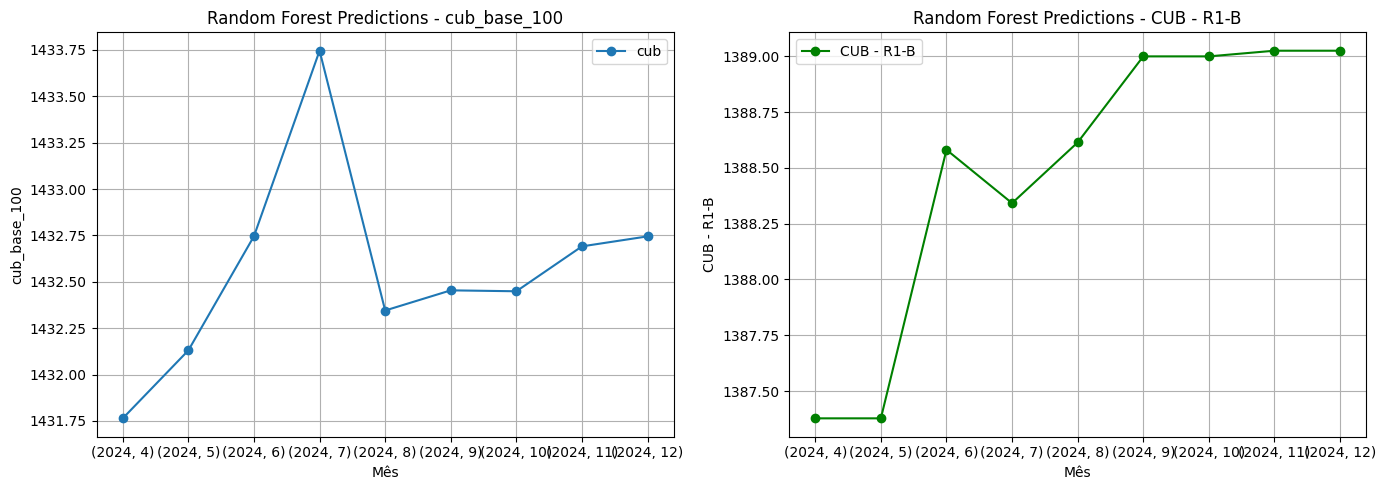

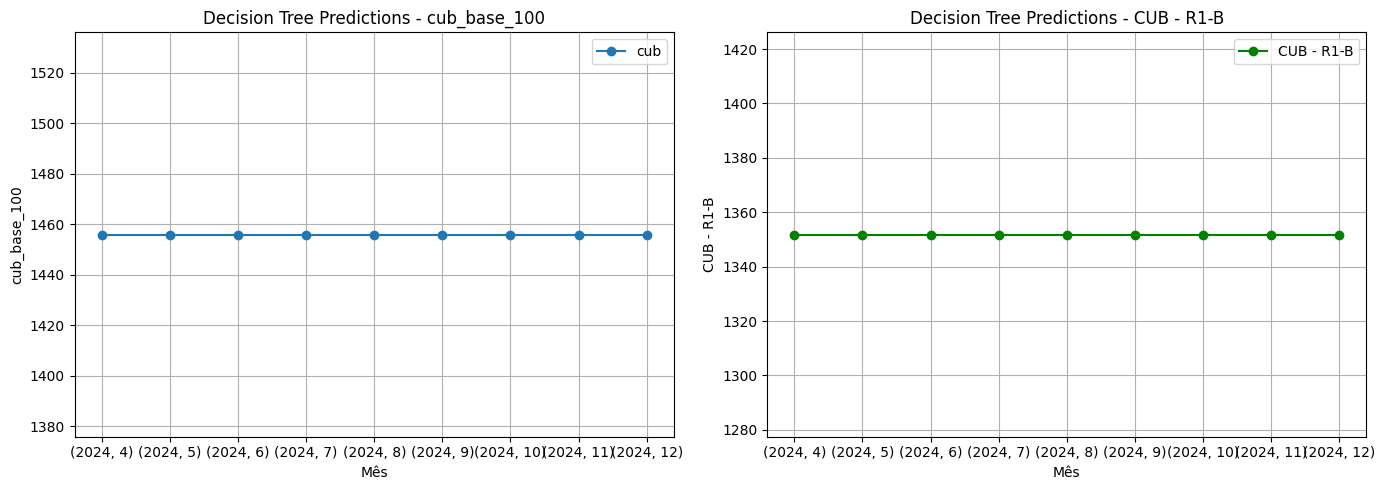

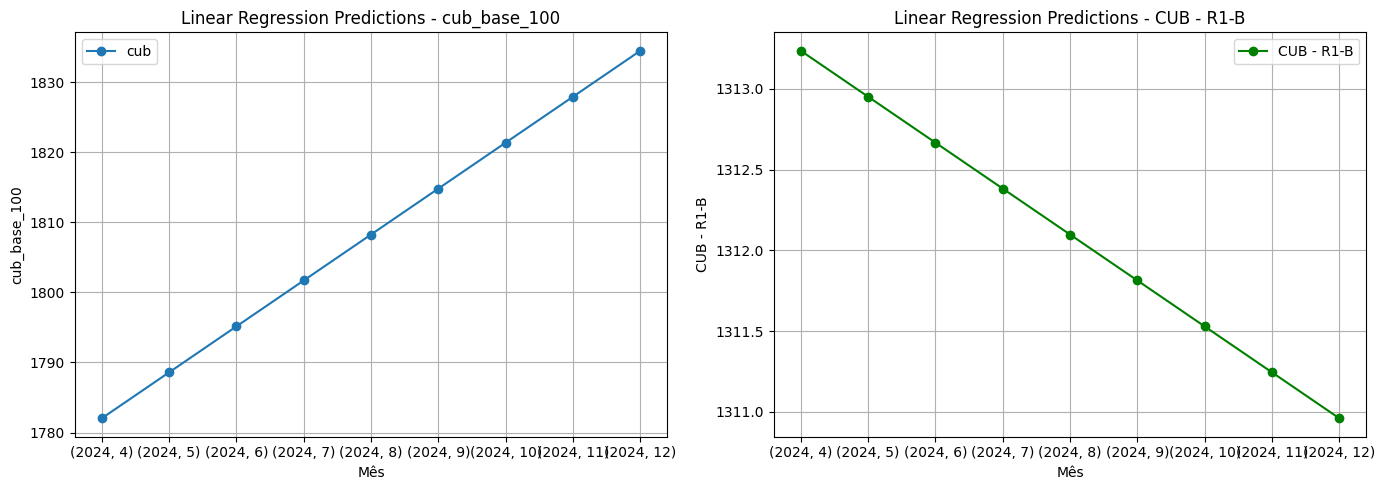

In [34]:
# Plotar previsões para Random Forest
plot_predictions(rf_df_1, rf_df_2, 'Random Forest Predictions')

# Plotar previsões para Decision Tree
plot_predictions(dt_df_1, dt_df_2, 'Decision Tree Predictions')

# Plotar previsões para Linear Regression
plot_predictions(lr_df_1, lr_df_2, 'Linear Regression Predictions')

In [35]:
## Exportando os arquivos em excel para transpor no TCC


# Caminho para salvar a o arquivo
file_path = r'D:\Google Drive\PC - Casa\MBA - USP ESALQ\Data Science\00. TCC\01. Base de Dados\Saída - Analise\00. Gráficos MAPE e MSE.xlsx'

# Criando um objeto ExcelWriter com o caminho completo
with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
    # Escreva cada dataframe em uma aba separada
    rf_df_1.to_excel(writer, sheet_name='RandomForest_base100', index=False)
    rf_df_2.to_excel(writer, sheet_name='RandomForest_abs', index=False)
    dt_df_1.to_excel(writer, sheet_name='DecisionTree_base100', index=False)
    dt_df_2.to_excel(writer, sheet_name='DecisionTree_abs', index=False)
    lr_df_1.to_excel(writer, sheet_name='LinearRegression_base100', index=False)
    lr_df_2.to_excel(writer, sheet_name='LinearRegression_abs', index=False)

### XG Boost
#### Os resultados do MAPE e MSE deram muito altos, logo iremos para um modelo mais robusto (o XG Boost) para chegar em resultados mais precisos

In [36]:
#Configurando para quando der display aparecer o dataframe inteiro.
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [37]:
#Substituindo os valores nulos pela mediana
median_values = df.median()
df = df.fillna(median_values)
df.fillna(median_values, inplace=True)

C:\Users\rique\AppData\Local\Temp\ipykernel_1124\2708624092.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(median_values)


In [38]:
# Remover linhas com valores ausentes nas colunas alvo
df = df.dropna(subset=['cub'])  

# Separar as colunas de entrada e saída
X = df[['base100_pim', 'base100_iabr', 'base100_ipca', 'base100_snic', 'base100_PIB-Brasil', 'base100_PIB-CC',
        'base100_IGMR', 'base100_lancadas_ABRAINC', 'base100_vendidas_ABRAINC', 'base100_distratadas_ABRAINC', 'base100_incc_di']]
y_cub = df['cub']

In [39]:
#Dividir um conjunto de dados em treino e teste
X_train, X_test, y_train_cub, y_test_cub = train_test_split(X, y_cub, test_size=0.2, random_state=42)

In [40]:
#treinando um modelo de regressão usando o XGBRegressor do pacote xgboost
model_cub = XGBRegressor()
model_cub.fit(X_train, y_train_cub)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
#Seleciona 6 números aleatórios e distintos do intervalo de 5, ordenando a lista em ordem crescente
def gerar_numeros_ordenados():
    numeros = sorted(random.sample(range(5, 24), 6))
    return numeros

In [42]:
#A função predict_future tem o objetivo de gerar previsões para um número especificado de meses à frente

def predict_future(data, model_cub, start_month='2024_03', months_ahead=6):
    start_date = pd.to_datetime(f'{start_month[:4]}-{start_month[5:]}-01')
    future_months = pd.date_range(start=start_date, periods=months_ahead+1, freq='ME')[1:].strftime('%Y_%m').tolist()
    cub_predictions = []
    #ipca_predictions = []

    # Selecionar os dados do mês de início
    X_future = data[data['anomes'] == start_month][['base100_pim', 'base100_iabr', 'base100_ipca', 'base100_snic', 'base100_PIB-Brasil', 'base100_PIB-CC',
                                                    'base100_IGMR', 'base100_lancadas_ABRAINC', 'base100_vendidas_ABRAINC', 'base100_distratadas_ABRAINC', 'base100_incc_di']]
    
    if X_future.empty:
        raise ValueError(f"No data found for the specified start month: {start_month}")
    
    aux = 0
    
    for month in range(months_ahead):
        num = gerar_numeros_ordenados()
            
        y_pred_cub = model_cub.predict(X_future)

        # Armazenar as previsões
        cub_predictions.append(y_pred_cub[0] + num[aux])

        # Atualizar X_future para o próximo mês
        X_future = X_future.copy()
       # X_future.iloc[0, X_future.columns.get_loc('base100_ipca')] = y_pred_ipca[0]
        aux = aux + 1

    # Criar um dataframe com as previsões
    predictions = pd.DataFrame({
        'Month': future_months,
        'CUB': cub_predictions,
        #'base100_ipca': ipca_predictions
    })

    return predictions

In [43]:
X_future = X_test.head(6)
y_pred_cub = model_cub.predict(X_future)

In [44]:
#Cálcula o MSE para o teste
y_test_pred_cub = model_cub.predict(X_test)
mse_cub = mean_squared_error(y_test_cub, y_test_pred_cub)

print("Mean Squared Error para o CUB:", mse_cub)
print("Predições para os próximos 6 meses do CUB (CUB):", y_pred_cub)

Mean Squared Error para o CUB: 1012.2755513294505
Predições para os próximos 6 meses do CUB (CUB): [1342.1989 1010.758  1804.7687 1377.5513 1345.4211 1113.8716]


In [45]:
#Cálculo do MAPE para o teste
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_cub = mean_absolute_percentage_error(y_test_cub, y_test_pred_cub)
print("MAPE para CUB:", mape_cub)

MAPE para CUB: 1.5558358822942164


In [46]:
#Usando a função criada para prever os dados futuros do CUB
predictions = predict_future(df, model_cub, start_month='2024_03', months_ahead=6)

In [47]:
#Renomeando as colunas para ter o mesmo nome do dataframe original
predictions = predictions.rename(columns={"Month" : "anomes", "CUB": "cub"})

In [48]:
#Unindo os valores preditos ao dataframe original
result = pd.concat([df, predictions], axis=0)

In [49]:
#Visualizando todo o dataframe
result.head(len(result))

,anomes,CUB - R1-B,PIM-PF,IABR,IPCA,SNIC,PIB-Brasil,PIB-CC,IGMR,Unidades lançadas (ABRAINC),Unidades vendidas (ABRAINC),Unidades distratadas (ABRAINC),incc_di,ano_mes,cub,base100_pim,base100_iabr,base100_ipca,base100_snic,base100_PIB-Brasil,base100_PIB-CC,base100_IGMR,base100_lancadas_ABRAINC,base100_vendidas_ABRAINC,base100_distratadas_ABRAINC,base100_incc_di
0,2012_01,943.91,126.9,784.3505,3633.44,5305205.0,1.7,8.7,101.100000,7866.5,9190.0,1798.5,492.106,2012_01,943.910000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
1,2012_02,946.59,127.2,784.3505,3655.24,5245702.0,1.7,8.7,101.100000,7866.5,9190.0,1798.5,493.584,2012_02,946.590000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
2,2012_03,954.13,139.7,784.3505,3672.42,6091824.0,1.7,8.7,101.100000,7866.5,9190.0,1798.5,496.079,2012_03,954.130000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
3,2012_04,957.98,129.1,784.3505,3692.62,5353569.0,1.0,1.8,101.100000,7866.5,9190.0,1798.5,499.791,2012_04,957.980000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
4,2012_05,971.04,140.0,784.3505,3706.28,6089147.0,1.0,1.8,101.100000,7866.5,9190.0,1798.5,509.184,2012_05,971.040000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
5,2012_06,981.08,132.7,784.3505,3715.92,5457812.0,1.0,1.8,101.100000,7866.5,9190.0,1798.5,512.903,2012_06,981.080000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
6,2012_07,994.31,139.0,784.3505,3717.03,6083429.0,2.5,2.9,101.100000,7866.5,9190.0,1798.5,516.318,2012_07,994.310000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
7,2012_08,996.84,147.1,784.3505,3725.95,6568943.0,2.5,2.9,101.100000,7866.5,9190.0,1798.5,517.657,2012_08,996.840000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
8,2012_09,998.34,137.5,784.3505,3738.99,5780603.0,2.5,2.9,101.100000,7866.5,9190.0,1798.5,518.816,2012_09,998.340000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674
9,2012_10,1001.47,148.4,784.3505,3760.30,6320059.0,2.5,-0.1,101.100000,7866.5,9190.0,1798.5,519.907,2012_10,1001.470000,82.428115,83.153479,126.325361,83.056823,88.864112,43.423424,101.100000,455.764774,118.580645,51.994796,132.336674


In [50]:
## Exportando os arquivos em excel para transpor no TCC


# Caminho para salvar a o arquivo
file_path = r'D:\Google Drive\PC - Casa\MBA - USP ESALQ\Data Science\00. TCC\01. Base de Dados\Saída - Analise\01. Resultado Final.xlsx'

# Criando um objeto ExcelWriter com o caminho completo
with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
    # Escreva cada dataframe em uma aba separada
    result.to_excel(writer, sheet_name='Base_Final', index=False)
    predictions.to_excel(writer, sheet_name='Valores_Preditos_CUB', index=False)
  

<Figure size 1400x700 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Month')

Text(0, 0.5, 'CUB')

Text(0.5, 1.0, 'CUB over Time')

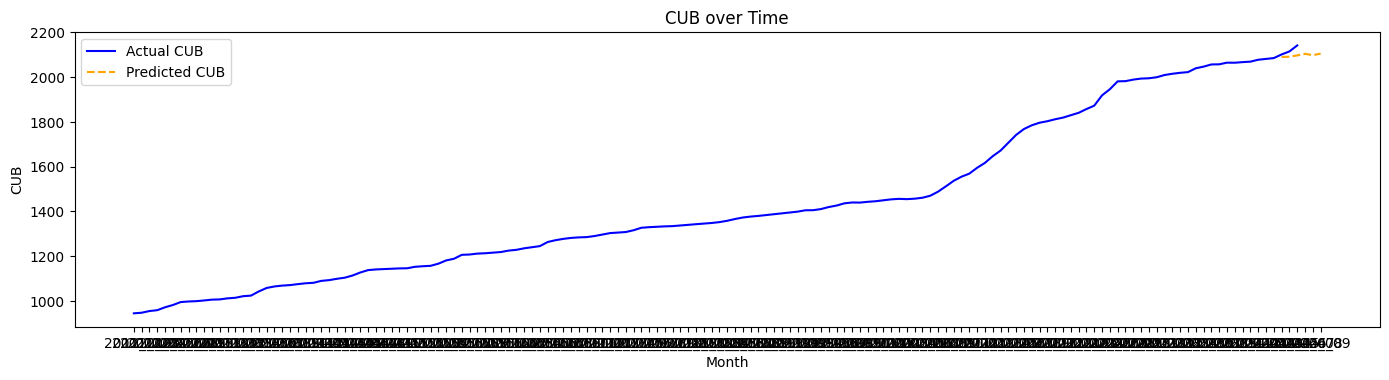

In [51]:
#Plot do gráfico com os valores do CUB e as predições
plt.figure(figsize=(14, 7))

# Gráfico para 'cub'
plt.subplot(2, 1, 1)
plt.plot(df['anomes'], df['cub'], label='Actual CUB', color='blue')
plt.plot(predictions['anomes'], predictions['cub'], label='Predicted CUB', color='orange', linestyle='--')
plt.xlabel('Month')
plt.ylabel('CUB')
plt.title('CUB over Time')
plt.legend()


plt.tight_layout()
plt.show()